### Robot Learning

### Assignment 4

Solutions are due on 13.05.2025 before the lecture.

### Introduction

If you have not done so for the previous sheet, please familiarize yourself with the environment for this assignment sheet by examining the following code cell, which simulates an agent attempting to travers a challenging racetrack by randomly accelerating or decelerating its car at each time step.

In [1]:
# for this weeks helper function, we need skimage. 
# if you have not done so already for the previous sheet, install it by uncommenting and running the line below
# make sure that you have started the jupyter notebook in your rl_25 python env
#!pip install scikit-image

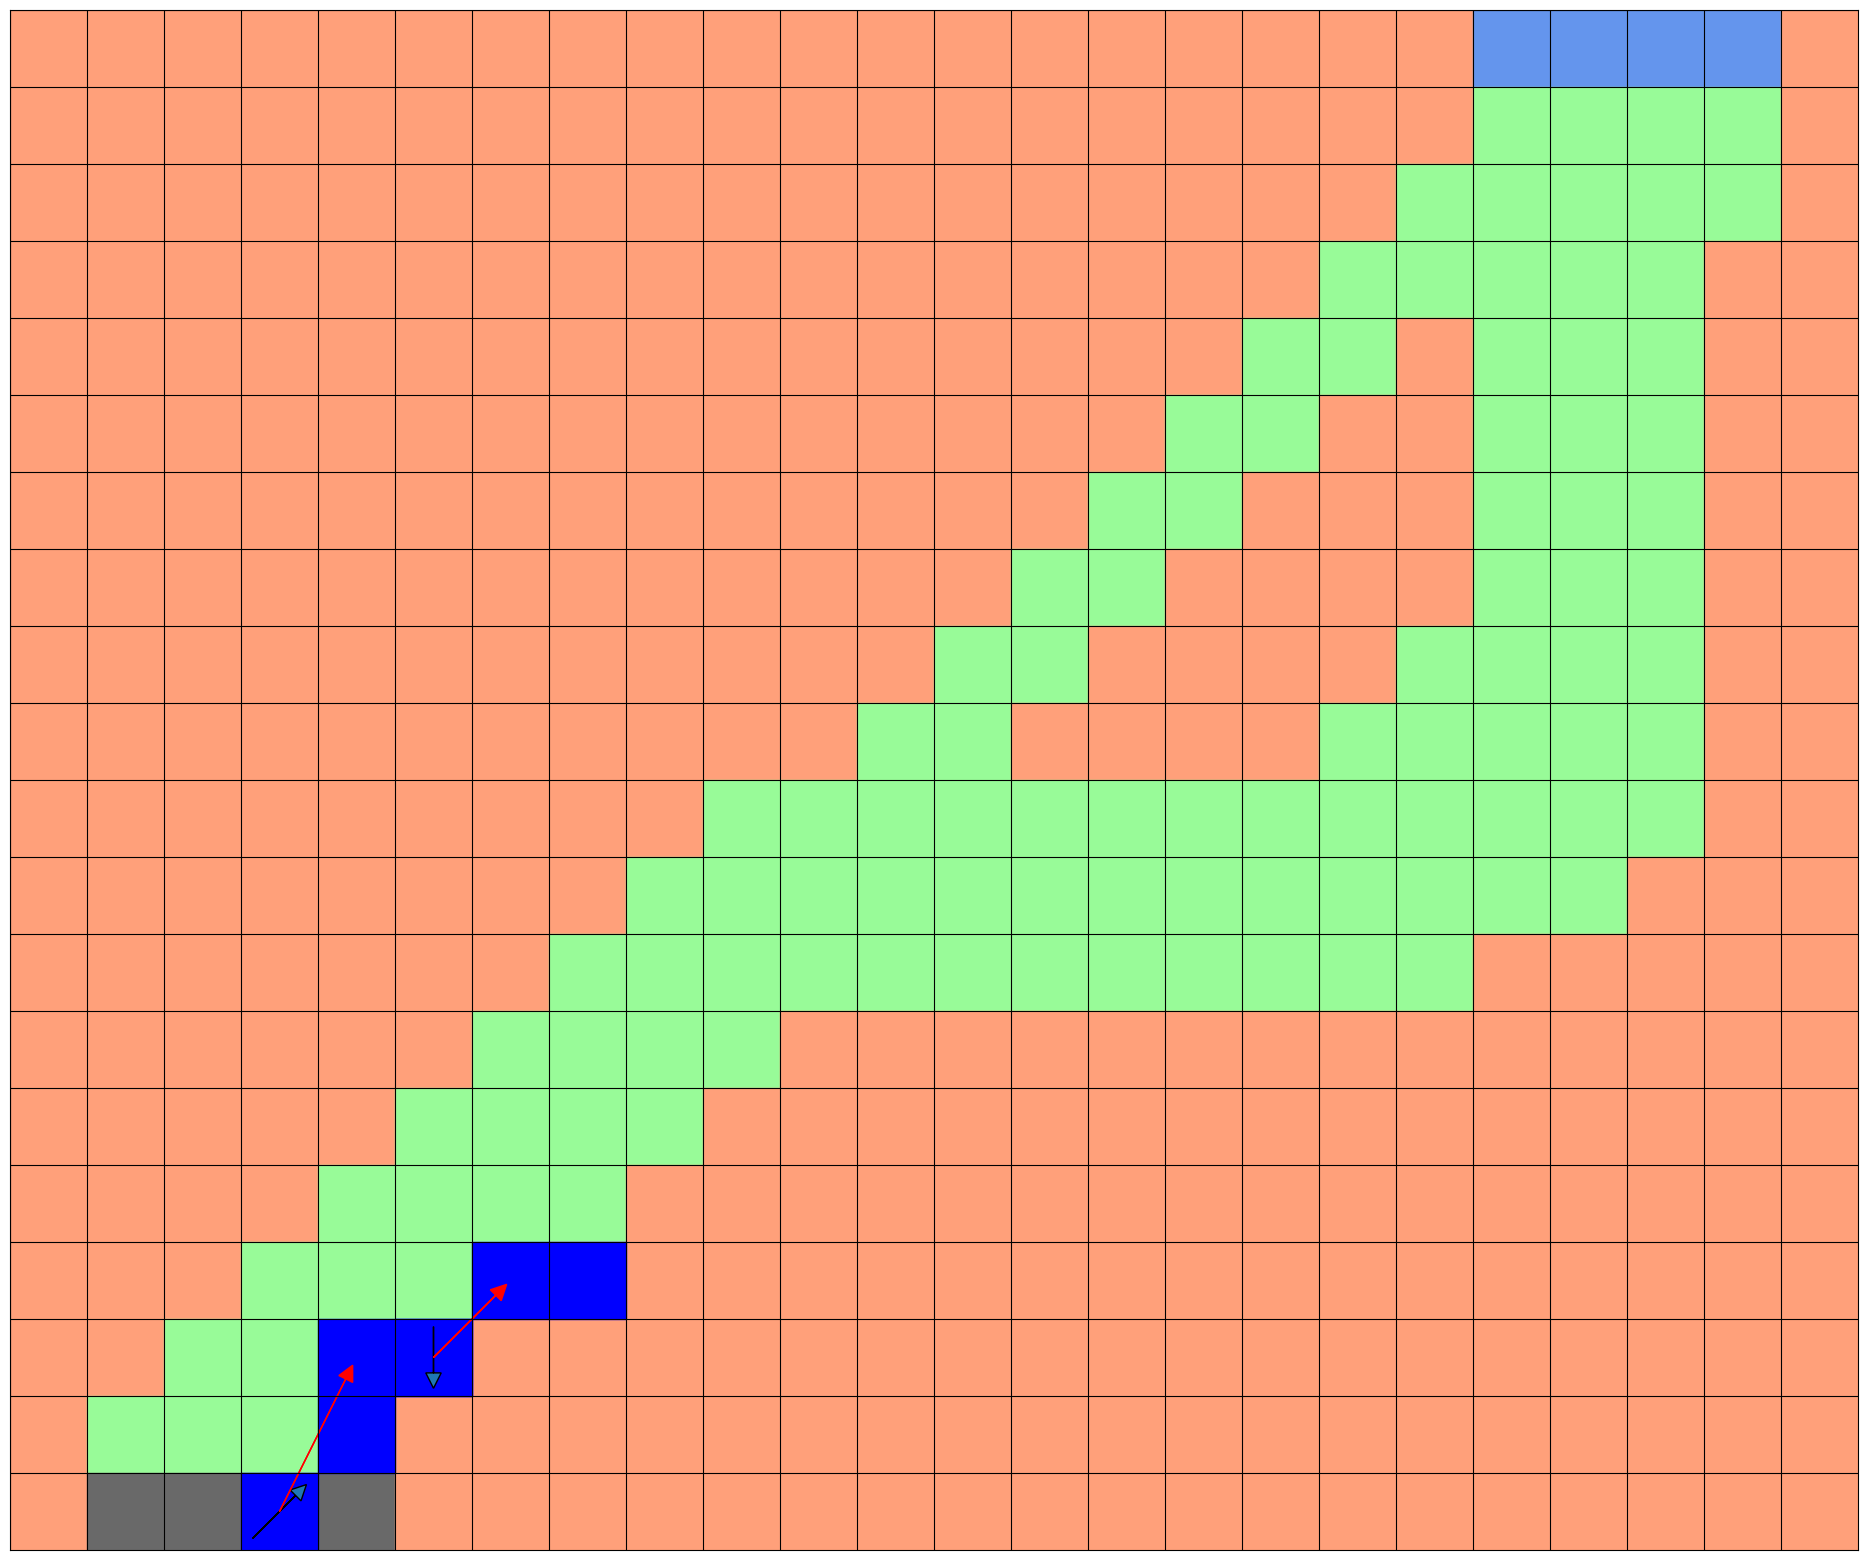

In [2]:
import numpy as np
# get the required helper class and visualization function
from helpers.utils import env, drawTrajectory, racetrack

np.random.seed(2025)

# create a racing environment
racer = env()
# reset the agent to one of the 4 starting cells at random
# do this before each new episode
racer.reset()
# you can also manually set the agent position if you want to examine its behaviour there
# for example: racer.setPosition(19,1)
# create flag tracking whether the episode is over
done = False

# create lists to save the trajectory and the decisions of the agent
actions = []
moves = []
velocities = []

# these following methods do what you would expect
# v is an integer in [0, 35] representing an encoded velocity
v = racer.getVelocity()
# y, x are both integers, together, they represent the agent location
y, x = racer.getPosition()
# together (y, x, v) corresponds to the state of the environment

# simulate until the episode is over
while not done:
    # which actions are possible at the current velocity?
    # the actions are encoded to integers in [0,8]
    possibleActions = racer.getAvailableActions()
    # select one of them randomly
    a = np.random.choice(possibleActions)
    # save the action
    actions.append(a)
    # execute the action using the step function
    # y, x, v are new positions and velocities
    # done is the flag whether the episode is over
    # travel details exactly which cells the agent traveled through
    y, x, v, r, done, travel = racer.step(action=a, deviation=True)
    # save the velocities
    velocities.append(v)
    # save the cells that the agent most recently passed through
    # they are only needed for visualization
    moves.append(travel)

# use the helper function to display how the episode went
drawTrajectory(moves, actions, velocities)

The agent enters the section on one of the gray cells at the bottom. Its initial velocity is one cell per time step into the upward direction.

Actions are to increase or decrease its velocity components by one or to leave it unchanged. To clarify, the actions are not to set a velocity, but to accelerate or decelerate. The velocity is thus part of the agent's state, the available actions are accelerations within the physical limitations of the vehicle that the agent is driving. The agent is not in full control of the vehicle and always moves one cell too far in either the horizontal or vertical direction.

Both velocity components are restricted to be nonnegative and their sum must be at least 1 and cannot exceed 6. This constrains the available actions based on the agent's current velocity.

The rewards are $-1.2$ for each step that the agent stays on the track, which is colored green. The reward is $−16$ if the agent drives into the crash barriers marked in red. The episode ends when the agent crashes or when it succesfully exits the section by driving onto the blue line at the top-right of the grid, yielding a reward of $14$.

As an output to the cell above, you get a visualization of the agent's path through the race track section. You can see several cells marked in dark blue. These are the grid cells that the agent passed through. Between two time steps, they are calculated by a line drawing algorithm given the current position and velocity of the agent, as well as the acceleration it selected. This acceleration is represented by the arrows with the blue tips. In some cases, a cell will instead contain a circle. This represents the action of no acceleration or deceleration at all, which means that the velocity stays the same as in the previous time step. The red arrows show the velocity of the agent at a certain step after the acceleration the agent selected is added to it.

## Task 4.1)

Compute an optimal policy  $\pi^*(s,a)$ for an agent on the windy (*deviation = True*) racetrack using Sarsa with $\alpha = 0.2$, $\gamma = 0.9$ and $\varepsilon = 0.1$ for $200000$ episodes.

To verify your algorithm, show one trajectory beginning in each of the $4$ starting positions. Deactivate exploratory actions and random environment deviations before presenting your agent's behaviour. 

<div style="text-align: right; font-weight:bold"> 10 Points </div>

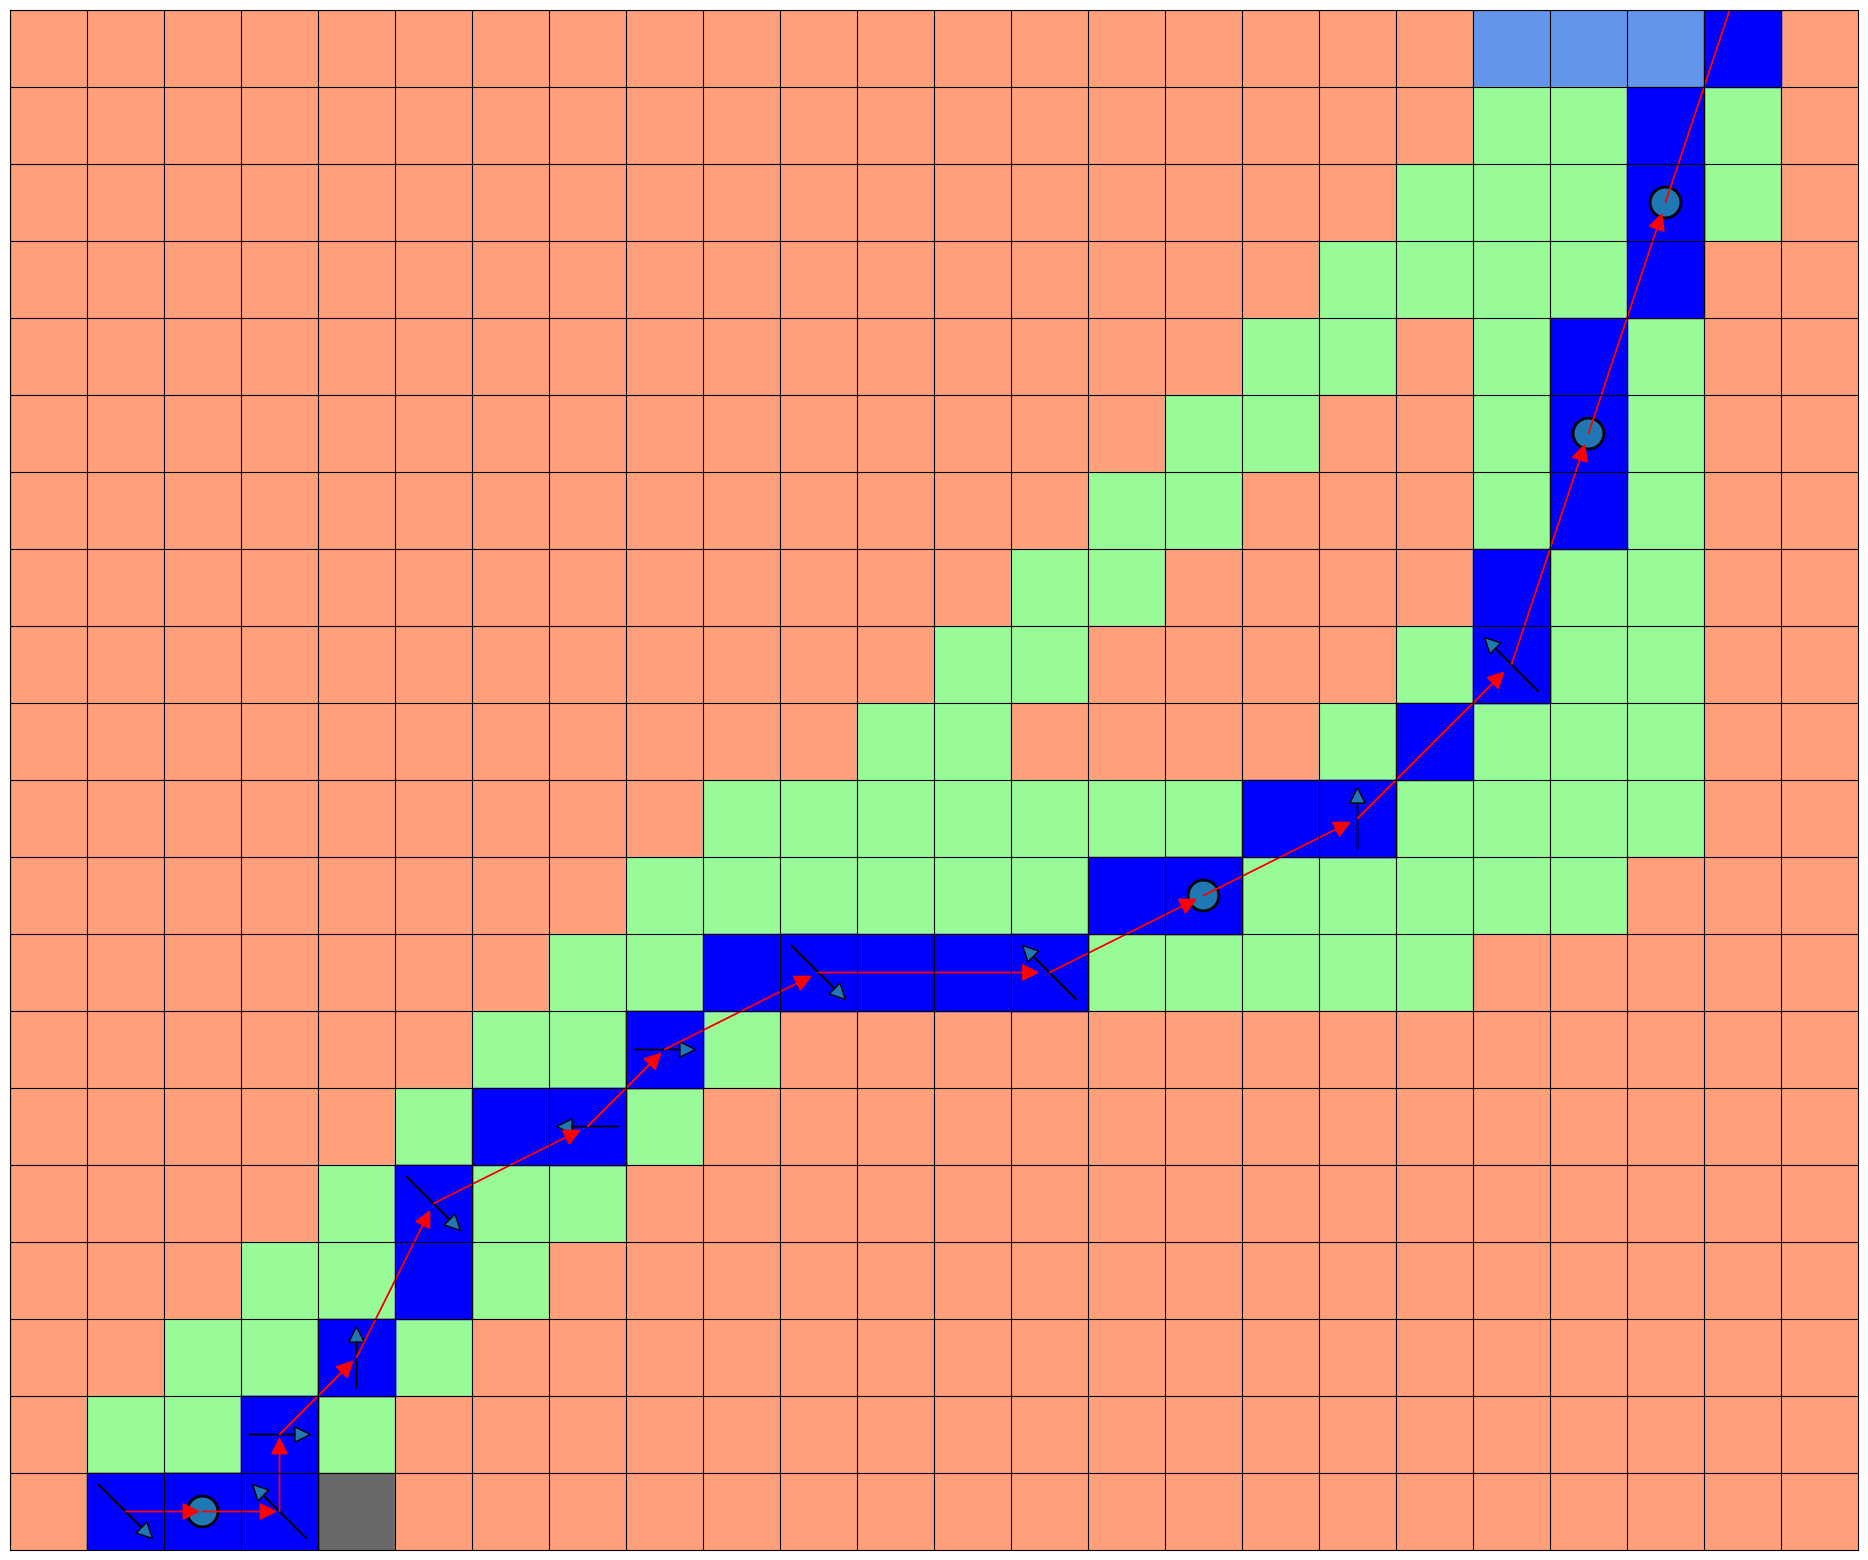

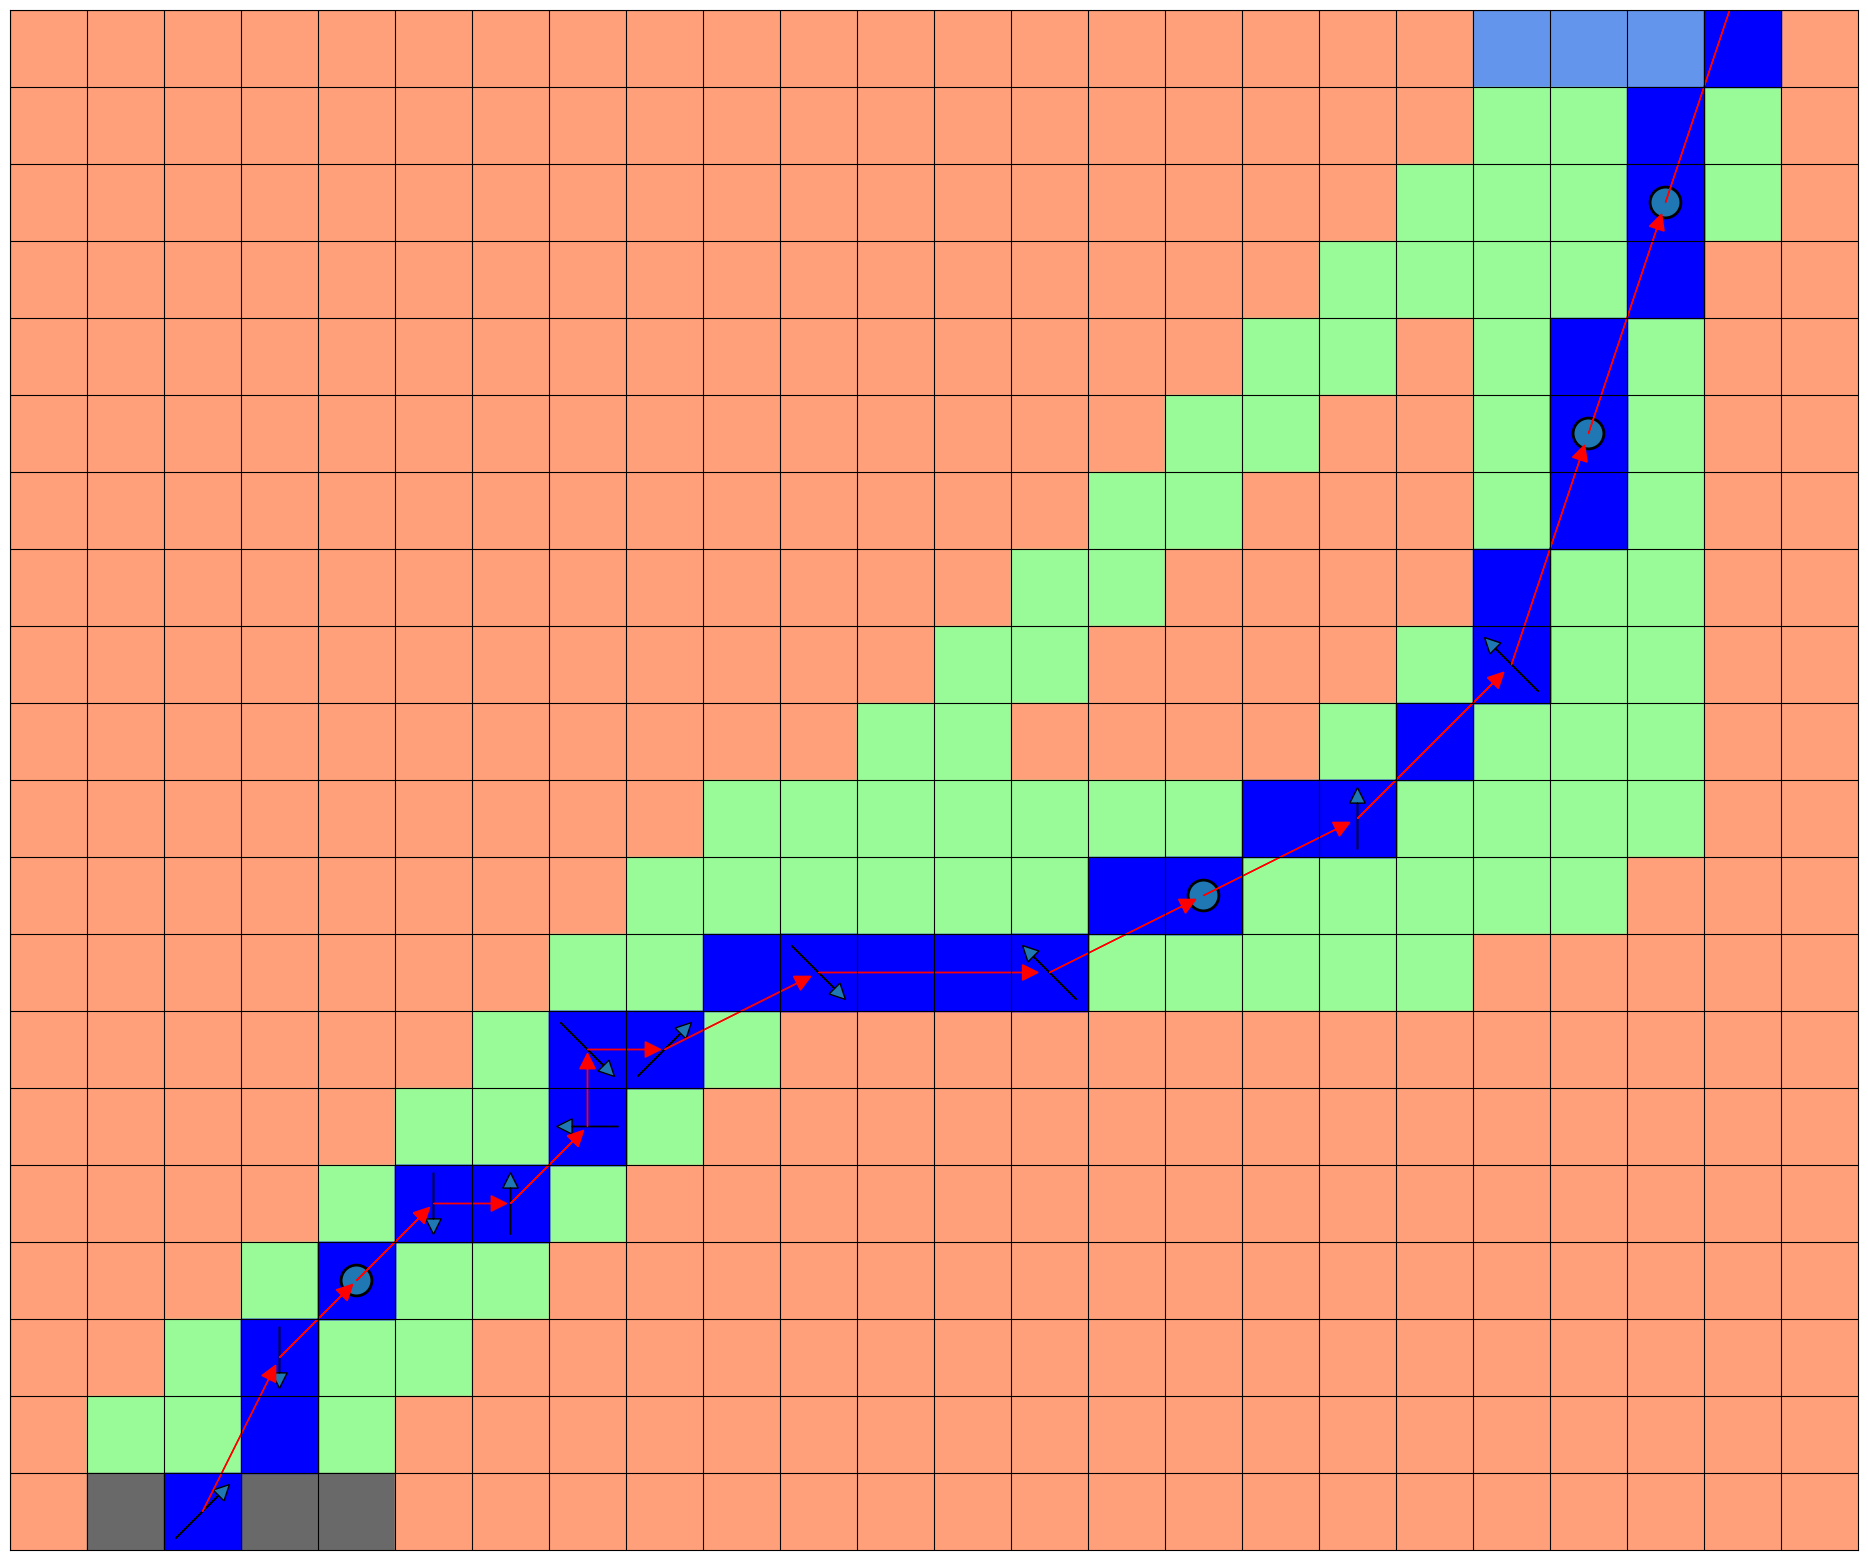

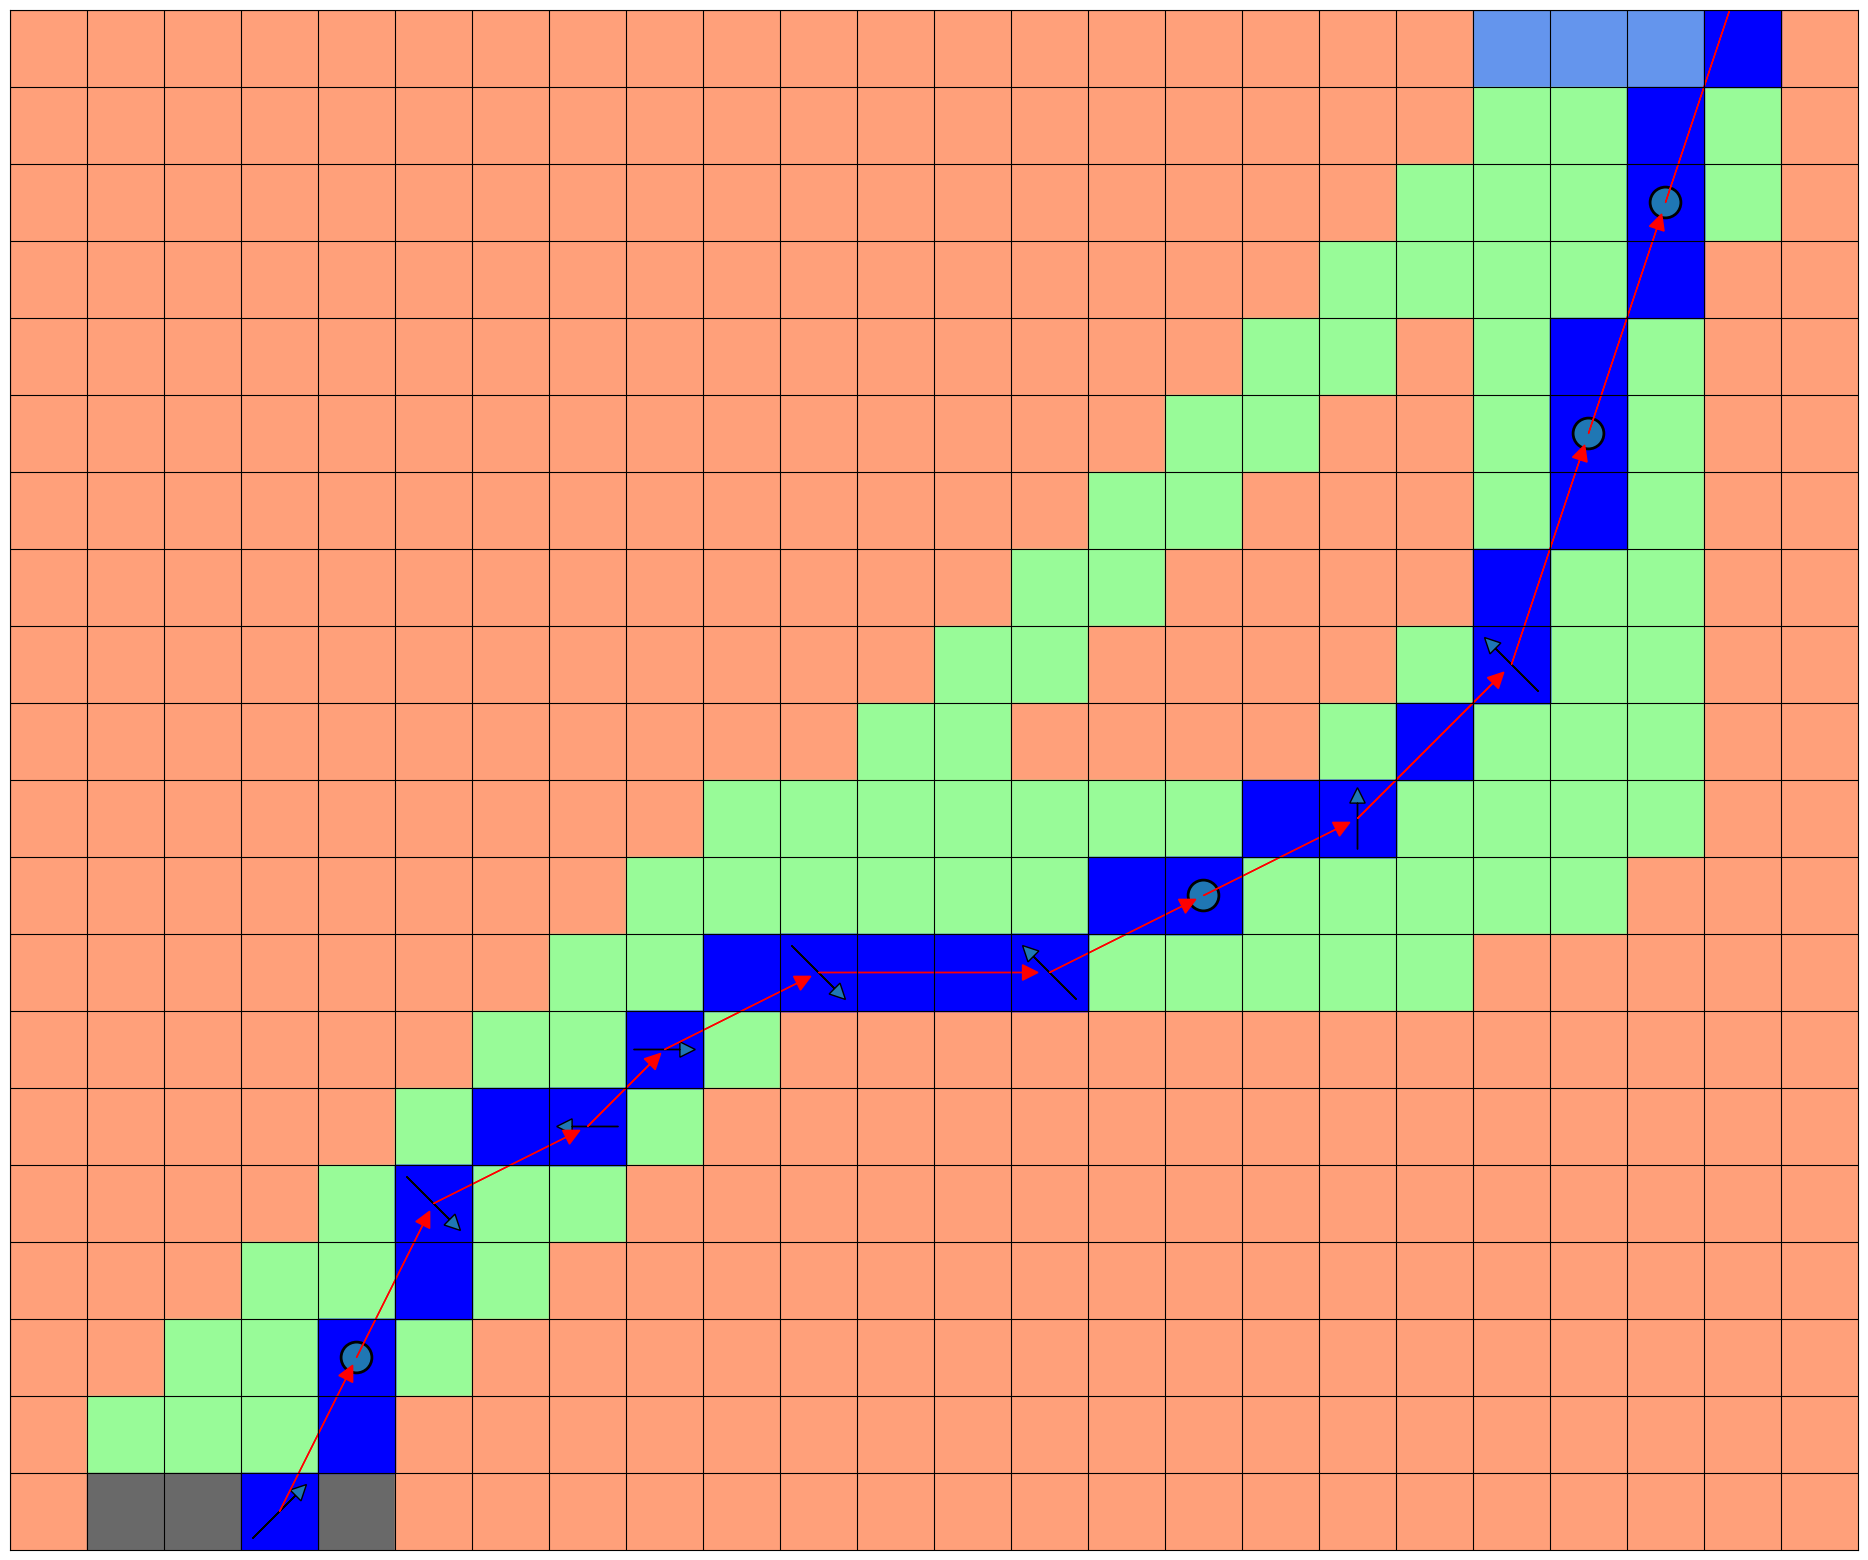

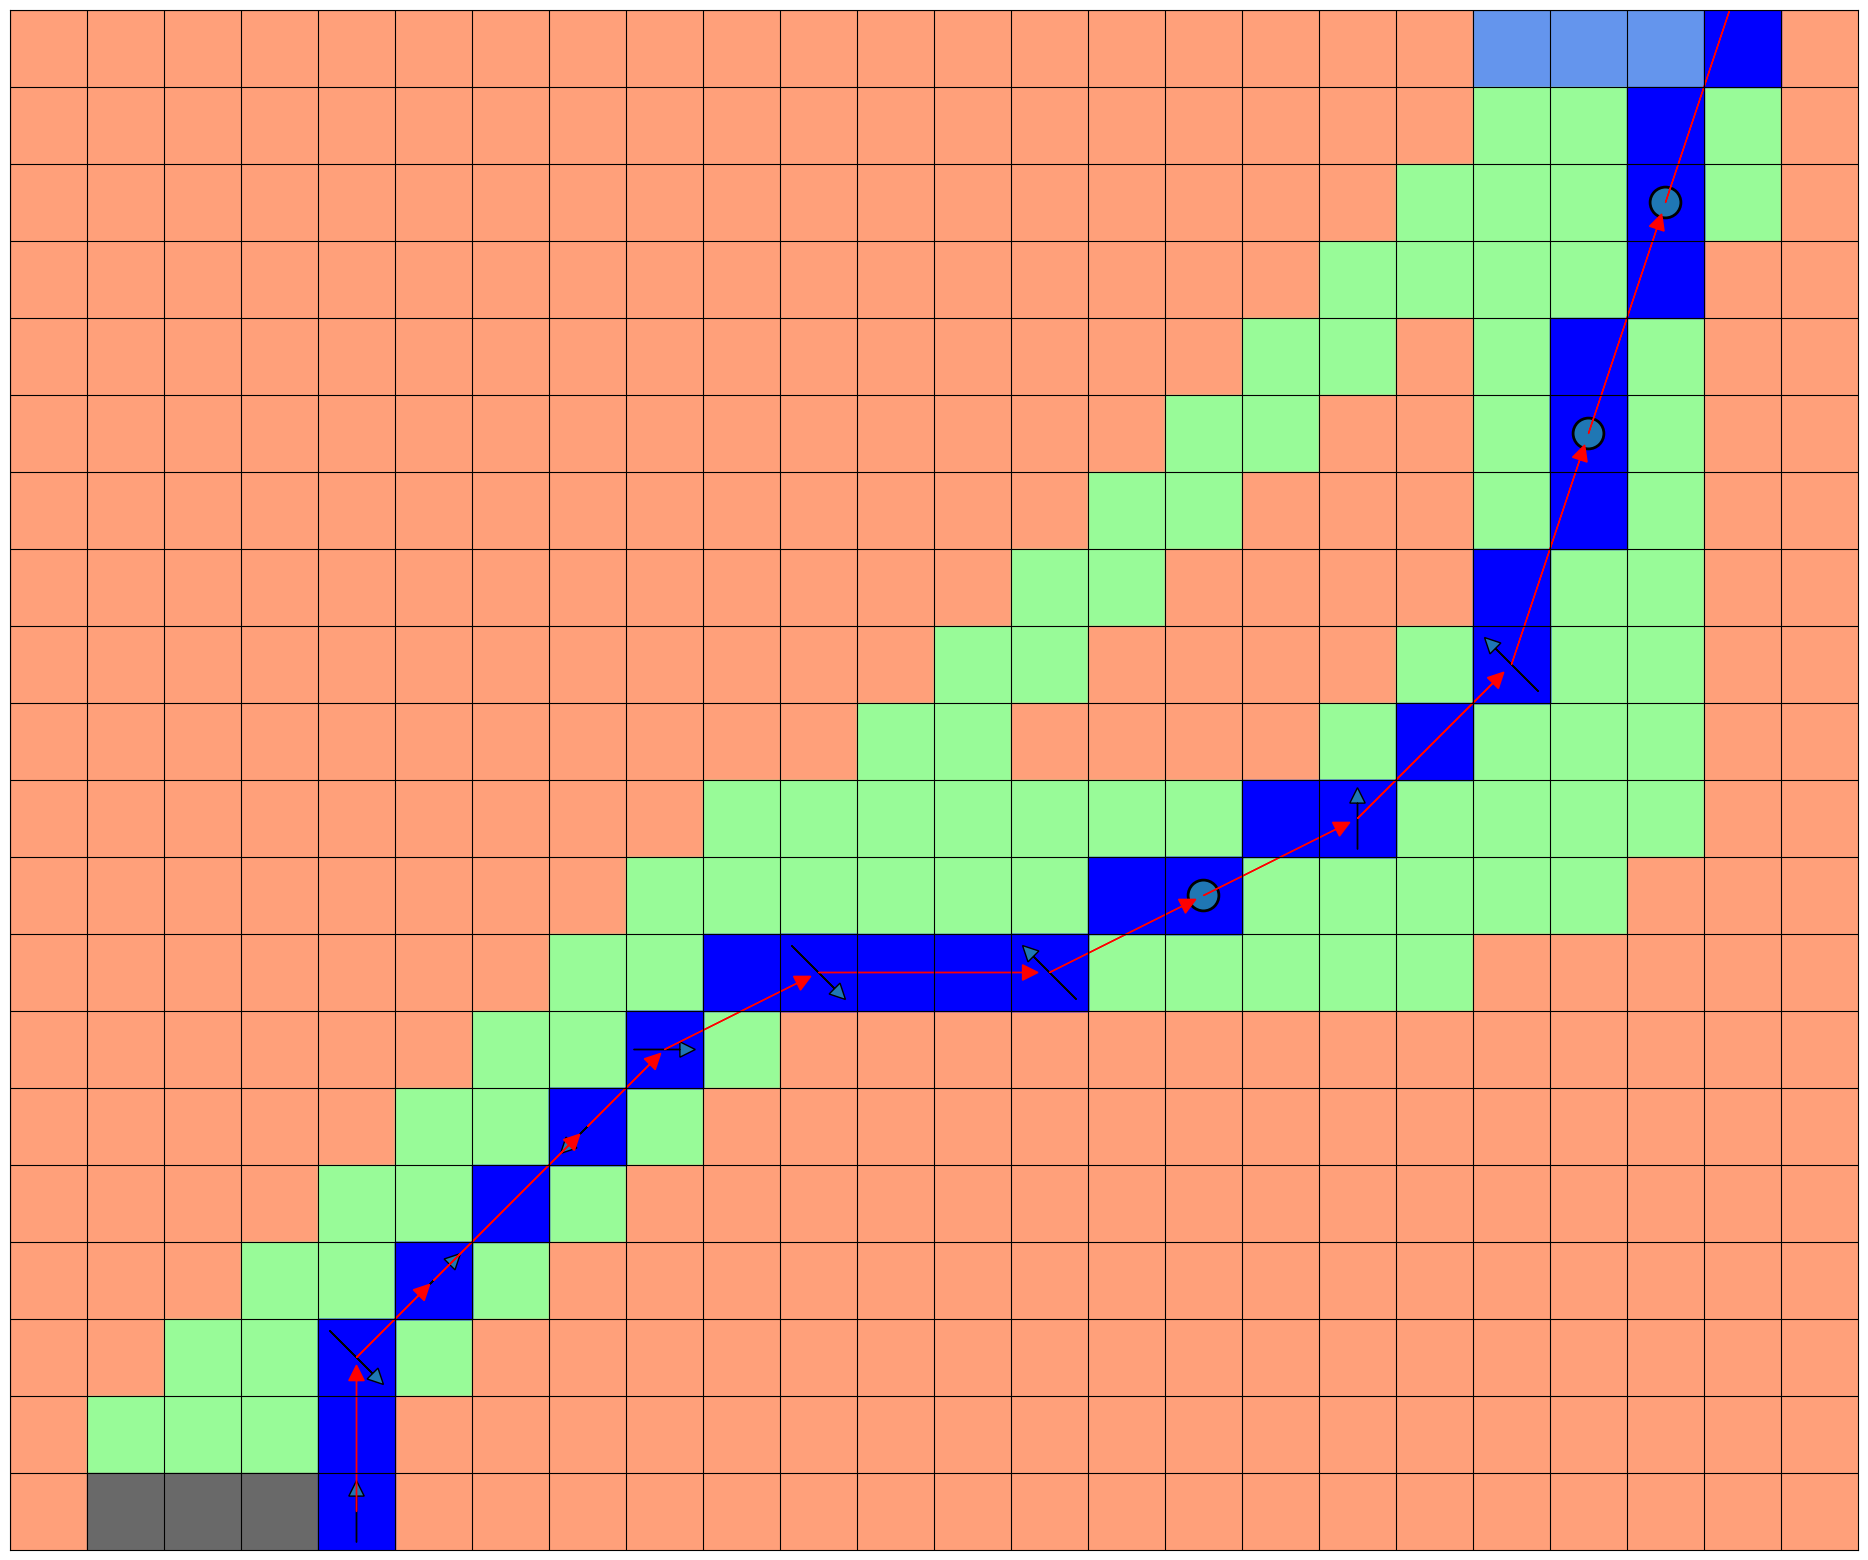

In [14]:
# for convenience, these are the cells that the agent can start in
startingGrid = [(19,x) for x in np.arange(1,5)]

# your code goes here
import numpy as np
from collections import defaultdict
from helpers.utils import env, drawTrajectory, racetrack

np.random.seed(2025)

# SARSA hyperparameters
alpha = 0.2
gamma = 0.9
epsilon = 0.1
episodes = 100000

# Create environment
racer = env()

# Discretize state: (y, x, velocity) with v in [0,35]
Q = defaultdict(lambda: np.zeros(9))  # 9 actions

def epsilon_greedy(state, possible_actions, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(possible_actions)
    else:
        q_values = np.array([Q[state][a] if a in possible_actions else -np.inf for a in range(9)])
        return np.argmax(q_values)

# Train SARSA
for ep in range(episodes):
    racer.reset()
    done = False
    y, x = racer.getPosition()
    v = int(racer.getVelocity().item())
    state = (y, x, v)
    possible_actions = racer.getAvailableActions()
    action = epsilon_greedy(state, possible_actions, epsilon)

    while not done:
        y_, x_, v_, reward, done, _ = racer.step(action, deviation=True)
        v_ = int(v_[0])
        next_state = (y_, x_, v_)
        next_possible = racer.getAvailableActions()
        next_action = epsilon_greedy(next_state, next_possible, epsilon)

        Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])

        state, action = next_state, next_action

# Evaluation from the 4 starting positions
startingGrid = [(19, x) for x in np.arange(1, 5)]

for pos in startingGrid:
    racer.reset()
    racer.setPosition(*pos)
    done = False
    actions = []
    moves = []
    velocities = []

    while not done:
        y, x = racer.getPosition()
        v = int(racer.getVelocity().item())
        state = (y, x, v)
        possible_actions = racer.getAvailableActions()
        # Exploit learned policy without randomness
        q_values = np.array([Q[state][a] if a in possible_actions else -np.inf for a in range(9)])
        action = np.argmax(q_values)

        actions.append(action)
        y_, x_, v_, r, done, travel = racer.step(action=action, deviation=False)
        velocities.append(v_)
        moves.append(travel)

    drawTrajectory(moves, actions, velocities)

## Task 4.2)

Again compute an optimal policy  $\pi^*(s,a)$ for an agent on the windy (*deviation = True*) racetrack. This time, use Q-learning with $\alpha = 0.2$, $\gamma = 0.9$ and $\varepsilon = 0.1$ for $200000$ episodes. To verify your algorithm, show one trajectory beginning in each of the $4$ starting positions. Deactivate exploratory actions and random environment deviations before presenting your agent's behaviour. 

Compare your results with those for Sarsa by reporting the cumulative moving average episode return of both algorithms during training in a plot. 

<div style="text-align: right; font-weight:bold"> 4+3 = 7 Points </div>

In [3]:
# your code goes here

## Task 4.3)

Note that the reward structure on this sheet differs from the previous assignment sheet, where driving on the track yielded a reward of $0.1$ instead of $-1.2$. Discuss whether it would be more or less difficult for Monte Carlo control algorithms to find a policy which is able to clear the racetrack in this scenario. Is there an advantage of using $-1.2$ as a reward?

<div style="text-align: right; font-weight:bold"> 3 Points </div>

Please answer in this text cell.